Why Random Forests?
Nonlinear, robust, handle mixed scales without scaling, capture interactions and nonlinearities, and are less sensitive to outliers than Logistic Regression.

Key hyperparameters tuned:

n_estimators (more trees reduce variance but cost time),

max_depth (controls tree depth; limiting reduces overfit),

min_samples_leaf (larger leaves make trees smoother/less overfit).
Also used class_weight="balanced_subsample" to mitigate class imbalance.

Metrics:
We keep PR-AUC as our main metric due to imbalance, plus Precision@Top-k% for the marketing use-case (who to contact).

Interpretability:
We showed Gini importances (fast) and optionally Permutation Importance (more reliable) to explain which features matter to the model.

In [14]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts.data_loader import load_caravan

In [15]:
# ---------------------------
# 1) Load data and names
# ---------------------------
train, test, X, y, TARGET = load_caravan(data_dir="./data")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (5822, 86)
Test shape: (4000, 85)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train/Val sizes:", X_train.shape, X_val.shape)
print("Positive rate (train/val):", round(y_train.mean(),4), round(y_val.mean(),4))


Train/Val sizes: (4657, 85) (1165, 85)
Positive rate (train/val): 0.0597 0.0601


In [17]:
from sklearn.ensemble import RandomForestClassifier

# Class imbalance: use class_weight="balanced_subsample" so each tree sees reweighted classes
rf = RandomForestClassifier(
    n_estimators=400,           # number of trees
    max_depth=None,             # allow trees to grow fully (we regularize via min_samples_leaf)
    min_samples_leaf=2,         # small leaf size to reduce overfitting a bit
    min_samples_split=5,        # avoid very tiny splits
    class_weight="balanced_subsample",
    n_jobs=-1,                  # use all CPU cores
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=400, n_jobs=-1,
                       random_state=42)

ROC-AUC: 0.7168
PR-AUC : 0.1381

Classification report @ 0.5
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1095
           1       0.15      0.09      0.11        70

    accuracy                           0.92      1165
   macro avg       0.55      0.53      0.53      1165
weighted avg       0.90      0.92      0.91      1165

Confusion matrix:
 [[1062   33]
 [  64    6]]
Precision@Top5%: 0.1379
Precision@Top10%: 0.1207


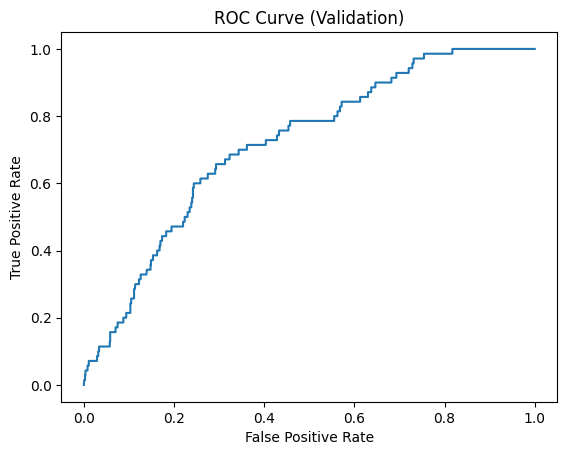

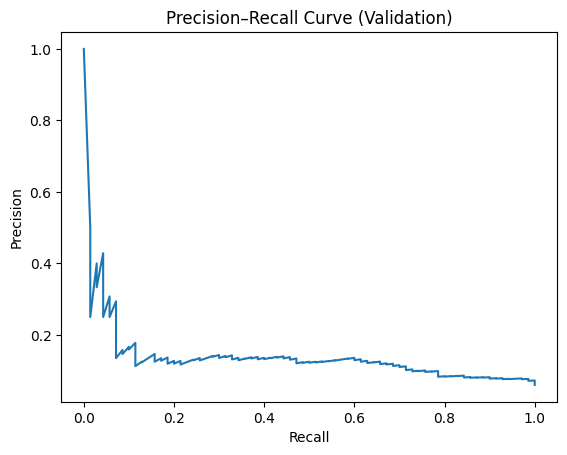

In [18]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)
import numpy as np

proba_val = rf.predict_proba(X_val)[:, 1]
preds_val = rf.predict(X_val)

roc = roc_auc_score(y_val, proba_val)
pra = average_precision_score(y_val, proba_val)
print("ROC-AUC:", round(roc, 4))
print("PR-AUC :", round(pra, 4))

print("\nClassification report @ 0.5")
print(classification_report(y_val, preds_val, zero_division=0))

cm = confusion_matrix(y_val, preds_val)
print("Confusion matrix:\n", cm)

def precision_at_k(y_true, scores, k=0.05):
    n = len(scores)
    top = max(1, int(k*n))
    idx = np.argsort(-scores)[:top]
    return float(y_true.iloc[idx].mean())

for k in [0.05, 0.10]:
    print(f"Precision@Top{int(k*100)}%:",
          round(precision_at_k(y_val, proba_val, k), 4))

# Curves (one per figure)
fpr, tpr, _ = roc_curve(y_val, proba_val)
plt.figure(); plt.plot(fpr, tpr); plt.title("ROC Curve (Validation)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.show()

precision, recall, _ = precision_recall_curve(y_val, proba_val)
plt.figure(); plt.plot(recall, precision); plt.title("Precision–Recall Curve (Validation)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()


ROC-AUC = 0.7168
Overall ranking quality across all thresholds. It’s above random (0.5), so the RF has signal, but it’s weaker than your Logistic Regression (~0.74).

PR-AUC = 0.1381
Area under the Precision–Recall curve. With a base rate ≈ 6% buyers, 0.138 is a modest lift over random, but worse than Logistic’s ~0.159. For imbalanced problems, PR-AUC is the more telling metric—RF is trailing here.

At the default threshold (0.5)
Confusion matrix
TN=1062  FP=33
FN=  64  TP= 6


Class 1 (buyers): precision 0.15, recall 0.09, F1 0.11.
Only 6 true positives out of 70 buyers are caught → the model is predicting “0” most of the time at the 0.5 cutoff.

Accuracy 0.92 looks high but is misleading with imbalance (predicting 0’s already yields ~94%); accuracy isn’t a good KPI here.

Campaign-style KPIs (more relevant)

Precision@Top5% = 13.8%

Precision@Top10% = 12.1%

These beat the base rate (~6%), so there is lift—but it’s quite a bit below Logistic’s ~22.4% (Top5%) and ~19.8% (Top10%). That means RF’s ranking of prospects is currently worse than Logistic’s on this split.

Why might RF underperform here?

Default-ish hyperparameters: Even with class_weight="balanced_subsample", RF may need tuning (e.g., max_depth, min_samples_leaf, n_estimators) to improve ranking.

Feature nature: Many features are coded categories / ordinal buckets. Logistic (with scaling) sometimes does surprisingly well here, while a plain RF can overfit noise or fail to rank well without careful depth/leaf constraints.

Thresholding: At 0.5, RF is extremely conservative (only 6 TPs). For this use-case, we usually don’t use a fixed 0.5. We either:

pick a threshold that gives a desired precision/recall trade-off, or

select the top-k% by probability (what you already report).

In [9]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

rf_base = RandomForestClassifier(
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10],
    "min_samples_leaf": [1, 3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

# IMPORTANT: fit only on the TRAIN split to avoid leakage
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best CV PR-AUC:", round(rf_grid.best_score_, 4))

rf_best = rf_grid.best_estimator_

# Evaluate tuned model on validation
proba_val_best = rf_best.predict_proba(X_val)[:, 1]
preds_val_best  = rf_best.predict(X_val)

roc_best = roc_auc_score(y_val, proba_val_best)
pra_best = average_precision_score(y_val, proba_val_best)
print("\n[Tuned RF] Validation ROC-AUC:", round(roc_best, 4))
print("[Tuned RF] Validation PR-AUC :", round(pra_best, 4))

for k in [0.05, 0.10]:
    print(f"[Tuned RF] Precision@Top{int(k*100)}%:",
          round(precision_at_k(y_val, proba_val_best, k), 4))


Best RF params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Best CV PR-AUC: 0.1658

[Tuned RF] Validation ROC-AUC: 0.7714
[Tuned RF] Validation PR-AUC : 0.1777
[Tuned RF] Precision@Top5%: 0.2586
[Tuned RF] Precision@Top10%: 0.2069
